In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import *
import os
import math
import random

from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from keras.layers import Conv2D, MaxPooling2D, concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras_squeezenet import SqueezeNet

from textwrap import wrap
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
%matplotlib inline
DIRECTORY_1 = '/home/joe/Dev/robot_direction_control/train_bat_1'
CSV_FILE_1 = '/home/joe/Dev/robot_direction_control/train_bat_1/maneuversave.csv'
filenames = os.listdir(DIRECTORY_1)
df1 = pd.read_csv(CSV_FILE_1)

DIRECTORY_2 = '/home/joe/Dev/robot_direction_control/train_bat_2'
CSV_FILE_2 = '/home/joe/Dev/robot_direction_control/train_bat_2/maneuversave.csv'
filenames = os.listdir(DIRECTORY_2)
df2 = pd.read_csv(CSV_FILE_2)

DIRECTORY_3 = '/home/joe/Dev/robot_direction_control/train_bat_3'
CSV_FILE_3 = '/home/joe/Dev/robot_direction_control/train_bat_3/maneuversave.csv'
filenames = os.listdir(DIRECTORY_3)
df3 = pd.read_csv(CSV_FILE_3)



width_height = 224
BATCH_SIZE = 144
#BATCH_SIZE = 10809
np.random.seed(42)

In [59]:
def load_image(filename1, filename2, filename3, filename4):
    img1 = cv2.imread('{}'.format(filename1))
    img2 = cv2.imread('{}'.format(filename2))
    img3 = cv2.imread('{}'.format(filename3))
    img4 = cv2.imread('{}'.format(filename4))
    img1 = cv2.resize(img1, (112, 112))
    img2 = cv2.resize(img2, (112, 112))
    img3 = cv2.resize(img3, (112, 112))
    img4 = cv2.resize(img4, (112, 112))

    output = np.zeros((225, 225, 3))
    output[0:112,0:112] = img1
    output[113:225,0:112] = img2
    output[0:112,113:225] = img3
    output[113:225,113:225] = img4
    return output[0:224,0:224]

def mean_normalize(img):
    return (img - img.mean()) / (img.max() - img.min())

def normalize(img):
    return img / 255

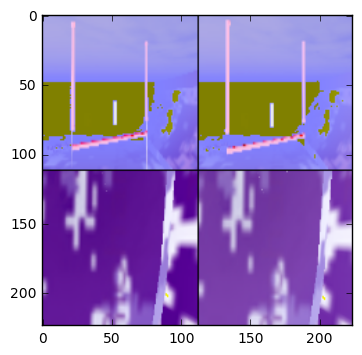

In [60]:
#hmnfwdL48.png hmndwnL48.png hmnfwdL49.png hmndwnL49.png
filename1 = DIRECTORY_2 + '/' + 'hmnfwdB2420.png'
filename2 = DIRECTORY_2 + '/' + 'hmndwnB2420.png'
filename3 = DIRECTORY_2 + '/' + 'hmnfwdB2421.png'
filename4 = DIRECTORY_2 + '/' + 'hmndwnB2421.png'
img = load_image(filename1, filename2, filename3, filename4)
plt.imshow(img)

In [61]:
def numpy_minmax(x):
    """
    to do: Define.
    """
    pass

In [62]:
def get_x_data(images_df, positions_df, num_rows, directory):
    """
    To Do redefine inputs
    """
    #images4 = pd.DataFrame(columns=['filename1','filename2','filename3','filename4'])
    x_data = []
    #x = positions_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled = min_max_scaler.fit_transform(positions_df)*.6
    scaled = scaled + .2
    #print(scaled.mean_,scaled_scale_)
    #x_pos_df = pd.DataFrame(scaled)
    for i in range(0, num_rows-1):
        dict_images = {'filename1': directory + '/' + images_df[i][0], 'filename2': directory + '/' + images_df[i][1],
                       'filename3': directory + '/' + images_df[i+1][0], 'filename4': directory + '/' + images_df[i+1][1],
                       'position.x': scaled[i][0],
                       'position.y': scaled[i][1],
                       'position.z': scaled[i][2],
                       'rotation.y': scaled[i][3],
                       'pathmarker1Points': scaled[i][3],
                       'buoy1Points': scaled[i][3],
                       'buoy2Points': scaled[i][3],
                       'buoy3Points': scaled[i][3],
                       'pathmarker2Points': scaled[i][3],
                       'maneuverPoints': scaled[i][3],
                       'pathmarker3Points': scaled[i][3],
                       'pathmarker4Points': scaled[i][3],
                       'pathmarker5Points': scaled[i][3],
                       'octagon1Points': scaled[i][3],
                       'pathmarker6Points': scaled[i][3],
                       'pathmarker7Points': scaled[i][3],
                       'octagon2Points': scaled[i][3]
                      }
        x_data.append(dict_images)
    df_x_data = pd.DataFrame(x_data, columns=['filename1', 'filename2', 'filename3', 'filename4',
                                                'position.x', 'position.y', 'position.z', 'rotation.y',
                                              'pathmarker1Points', 'buoy1Points', 'buoy2Points', 'buoy3Points',
                                              'pathmarker2Points', 'maneuverPoints', 'pathmarker3Points',
                                             'pathmarker4Points', 'pathmarker5Points', 'octagon1Points',
                                              'pathmarker6Points','pathmarker7Points','octagon2Points'])
    return df_x_data

In [63]:
def is_nan(value):
    if value > 0:
        return False
    if value < 0:
        return False
    if value == 0:
        return False
    return True

my_nan = np.nan
print(is_nan(my_nan))

True


In [64]:
def convert_y_wasd(input_value):
    if input_value == False:

        return 0
    if input_value == True:
        return 1
    return input_value

In [65]:
def get_y_data(positions_df, num_rows):
    """
    To do redefine inputs
    """
    y_data = []
    for i in range(0, num_rows-1):
        dict_images = {'mousex': positions_df[i+1][0], 'mousey': positions_df[i+1][1],
                       'W': convert_y_wasd(positions_df[i+1][0]),
                       'A': convert_y_wasd(positions_df[i+1][1]),
                       'S': convert_y_wasd(positions_df[i+1][2]),
                       'D': convert_y_wasd(positions_df[i+1][3])}
        y_data.append(dict_images)
    df_y_data = pd.DataFrame(y_data, columns=['mousex','mousey','W','A','S','D'])
    return df_y_data

In [66]:
def get_y_data_frame(data_frame):
    data_frame = data_frame.fillna(0)
    num_rows = len(data_frame.index)
    positions_df = data_frame[['mousex','mousey','W','A','S','D']].values
    return get_y_data(positions_df, num_rows)
get_y_data_frame(df1)

,mousex,mousey,W,A,S,D
0,-0.5,34,-0.5,34,1,0
1,-0.5,34,-0.5,34,1,0
2,-0.5,32,-0.5,32,1,0
3,-1.5,34,-1.5,34,1,0
4,-2.5,34,-2.5,34,1,0
5,-2.5,34,-2.5,34,1,0
6,-2.5,34,-2.5,34,1,0
7,-2.5,34,-2.5,34,1,0
8,-2.5,34,-2.5,34,1,0
9,-2.5,34,-2.5,34,1,0


In [67]:
def get_class_weights():
    data = get_y_data_frame(df1)
    max_val = data.max(axis=0)
    min_val = data.min(axis=0)
    delta = max_val - min_val
    class_weights = (1.0 / delta.values)/ 8
    return class_weights
get_class_weights()

array([ 0.00065104,  0.00183824,  0.00065104,  0.00183824,  0.125     ,
        0.125     ])

In [68]:
def get_x_data_frame(data_frame, directory):
    data_frame = data_frame.fillna(0)
    num_rows = len(data_frame.index)
    images_df = data_frame[['filename1','filename2']].values
    non_image_df = data_frame[['position.x','position.y','position.z','rotation.y']].values
    return get_x_data(images_df, non_image_df, num_rows, directory)
test_dataframe_values = (get_x_data_frame(df1, DIRECTORY_1))

In [69]:
#X = get_x_data(images_df, positions_df, num_rows).values
X = get_x_data_frame(df1, DIRECTORY_1)
X = X.append(get_x_data_frame(df2, DIRECTORY_2), ignore_index=True)
X = X.append(get_x_data_frame(df3, DIRECTORY_3), ignore_index=True)
#X = X.append(get_x_data_frame(df4, DIRECTORY_4), ignore_index=True)
#X = X.append(get_x_data_frame(df5, DIRECTORY_5), ignore_index=True)
y = get_y_data_frame(df1)
y = y.append(get_y_data_frame(df2), ignore_index=True)
y = y.append(get_y_data_frame(df3), ignore_index=True)
#y = y.append(get_y_data_frame(df4), ignore_index=True)
#y = y.append(get_y_data_frame(df5), ignore_index=True)
#y = get_y_data(positions_df, num_rows).values
X

,filename1,filename2,filename3,filename4,position.x,position.y,position.z,rotation.y,pathmarker1Points,buoy1Points,...,buoy3Points,pathmarker2Points,maneuverPoints,pathmarker3Points,pathmarker4Points,pathmarker5Points,octagon1Points,pathmarker6Points,pathmarker7Points,octagon2Points
0,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,0.800000,0.800000,0.200000,0.656955,0.656955,0.656955,...,0.656955,0.656955,0.656955,0.656955,0.656955,0.656955,0.656955,0.656955,0.656955,0.656955
1,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,0.798980,0.793717,0.200791,0.656903,0.656903,0.656903,...,0.656903,0.656903,0.656903,0.656903,0.656903,0.656903,0.656903,0.656903,0.656903,0.656903
2,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,0.797947,0.787358,0.201593,0.656850,0.656850,0.656850,...,0.656850,0.656850,0.656850,0.656850,0.656850,0.656850,0.656850,0.656850,0.656850,0.656850
3,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,0.796501,0.779039,0.202715,0.656776,0.656776,0.656776,...,0.656776,0.656776,0.656776,0.656776,0.656776,0.656776,0.656776,0.656776,0.656776,0.656776
4,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,0.795018,0.769918,0.203867,0.656553,0.656553,0.656553,...,0.656553,0.656553,0.656553,0.656553,0.656553,0.656553,0.656553,0.656553,0.656553,0.656553
5,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,0.793656,0.761546,0.204926,0.656214,0.656214,0.656214,...,0.656214,0.656214,0.656214,0.656214,0.656214,0.656214,0.656214,0.656214,0.656214,0.656214
6,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,0.792343,0.753486,0.205949,0.655887,0.655887,0.655887,...,0.655887,0.655887,0.655887,0.655887,0.655887,0.655887,0.655887,0.655887,0.655887,0.655887
7,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,0.790941,0.744880,0.207043,0.655538,0.655538,0.655538,...,0.655538,0.655538,0.655538,0.655538,0.655538,0.655538,0.655538,0.655538,0.655538,0.655538
8,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,0.789561,0.736415,0.208123,0.655195,0.655195,0.655195,...,0.655195,0.655195,0.655195,0.655195,0.655195,0.655195,0.655195,0.655195,0.655195,0.655195
9,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,/home/joe/Dev/robot_direction_control/train_ba...,0.788128,0.727629,0.209246,0.654838,0.654838,0.654838,...,0.654838,0.654838,0.654838,0.654838,0.654838,0.654838,0.654838,0.654838,0.654838,0.654838


In [74]:
n_features = 1
n_classes = y.shape[1]
print(y)

X, y = shuffle(X.values, y.values)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
print(X_train)
print('We\'ve got {} feature rows and {} labels'.format(len(X_train), len(y_train)))
print('Each row has {} features'.format(n_features))
print('and we have {} classes'.format(n_classes))
assert(len(y_train) == len(X_train))
print('We use {} rows for training and {} rows for validation'.format(len(X_train), len(X_valid)))
print('So far, so good')

[[   1.     4.     1.     4.     1.     0. ]
 [ 766.5  370.5  766.5  370.5    1.     0. ]
 [  26.5   42.5   26.5   42.5    1.     0. ]
 ..., 
 [  11.   -19.    11.   -19.     1.     0. ]
 [  23.5   17.5   23.5   17.5    1.     0. ]
 [ 655.5  322.5  655.5  322.5    1.     0. ]]


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [14]:
images = Input(shape=(224,224,3),name = 'image_input')
non_image_df = Input(shape=(14,),name = 'non_image_input')
inception_v3_model = InceptionV3(weights='imagenet', include_top=False)
for layer in inception_v3_model.layers:
    layer.trainable=False
inception_v3_model.summary()

#Use the generated model 
inception_v3_model_conv = inception_v3_model(images)
#forward = GlobalAveragePooling2D()(inception_v3_model_conv)
cnn = GlobalAveragePooling2D()(inception_v3_model_conv)
final = concatenate([cnn, non_image_df])    #forward
final = Dense(1024,activation="relu")(final)
final = Dropout(0.5)(final)
final = Dense(1024,activation="relu")(final)
final = Dropout(0.5)(final)
final = Dense(6, activation='linear')(final)

#Create model 
model = Model(input=[images, non_image_df], output=final)

#In the summary, weights and layers from InceptionV3 part will be hidden, but they will be fit during the training
model.summary()
#model.add(Dense(2,1,init=’uniform’, activation=’linear’))
#model.compile(loss='mse', optimizer='rmsprop')
adam = Adam(lr=0.001, clipvalue=1.5)
model.compile(loss='mse', optimizer=adam)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

/home/joe/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [15]:
def generator(X, y, batch_size=BATCH_SIZE):
    X_copy, y_copy = X, y
    while True:
        for i in range(0, len(X_copy), batch_size):
            X_image, X_positions, y_result = [], [], []
            if i<len(X_copy):
                for x, y in zip(X_copy[i:i+batch_size], y_copy[i:i+batch_size]):
                    #print('x[0], x[1], x[2], x[3]', x[0], x[1], x[2], x[3])
                    try:
                        rx1, rx2, ry = [normalize(load_image(x[0], x[1], x[2], x[3]))], [x[4] + random.gauss(0, .08)
                                                                                         ,x[5] + random.gauss(0, .08)
                                                                                         ,x[6] + random.gauss(0, .08)
                                                                                         ,x[7] + random.gauss(0, .08)
                                                                                         ,x[8]
                                                                                         ,x[9]
                                                                                         ,x[10]
                                                                                         ,x[11]
                                                                                         ,x[12]
                                                                                         ,x[13]
                                                                                         ,x[14]
                                                                                         ,x[15]
                                                                                         ,x[16]
                                                                                         ,x[17]
                                                                                            ], [y]
                        #print(x[0], x[1], x[2], x[3])
                        y = np.array(ry)
                        X_image.append(rx1)
                        X_positions.append([rx2])
                        y_result.append(y)
                    except:
                        pass
                X_result_1, X_result_2, y_result = np.concatenate(X_image), np.concatenate(X_positions), np.concatenate(y_result)
                yield [X_result_1, X_result_2], y_result
                #print(y_result)
                #yield X_result_1, y_result
        #X_copy, y_copy = shuffle(X_copy, y_copy)

In [ ]:
gen = generator(X_train, y_train)

In [ ]:
test_x, test_y = next(gen)

In [ ]:
test_x

In [16]:
EPOCHS = 20
PER_EPOCH = 10

class_w = get_class_weights()
filepath="/home/joe/Dev/robot_direction_control/models/InceptionV3_fc512_X2_pos-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit_generator(
    generator(X_train, y_train),
    steps_per_epoch=PER_EPOCH,
    epochs=EPOCHS,
    validation_data=generator(X_valid, y_valid),
    #validation_steps=len(y_valid)//(BATCH_SIZE),
    class_weight = class_w,
    validation_steps=2,
    callbacks=callbacks_list
)

Epoch 1/20
10/10 [==============================] - 228s - loss: 4720.4403 - val_loss: 5326.1784
Epoch 2/20
10/10 [==============================] - 283s - loss: 4699.6811 - val_loss: 5307.6430
Epoch 3/20
10/10 [==============================] - 306s - loss: 4635.0157 - val_loss: 5236.0584
Epoch 4/20
10/10 [==============================] - 362s - loss: 4500.1904 - val_loss: 5137.6206
Epoch 5/20
10/10 [==============================] - 399s - loss: 4338.1070 - val_loss: 5155.6959
Epoch 6/20
10/10 [==============================] - 453s - loss: 4135.2261 - val_loss: 5070.3917
Epoch 7/20
10/10 [==============================] - 489s - loss: 3951.4144 - val_loss: 5052.5860
Epoch 8/20
10/10 [==============================] - 491s - loss: 3678.3614 - val_loss: 4976.6281
Epoch 9/20
10/10 [==============================] - 518s - loss: 3491.8711 - val_loss: 4957.0151
Epoch 10/20
10/10 [==============================] - 526s - loss: 3429.7197 - val_loss: 4651.1232
Epoch 11/20
10/10 [==========

In [72]:
list_X_valid = list(X_valid)
list_y_valid = list(y_valid)
for i in range(0, len(list_X_valid)):
    list_fil = list(list_X_valid[i])
    print('')
    print('')
    print(i)
    print('actual pos: ', list_y_valid[i])
    print('image1: ', list_fil[0])
    print('image2: ', list_fil[1])
    print('image3: ', list_fil[2])
    print('image4: ', list_fil[3])
    try:
        img = normalize(load_image(list_fil[0], list_fil[1], list_fil[2], list_fil[3]))
        '''
       # display(
      #  sample_images,
     #   cols=1#,
        #titles=[t for t in samples['filename1']]
    #)
    '''
    #    pre_img = preprocess(img)
        pre_img = img.reshape((1, width_height, width_height, 3))
    #    print(pre_img.shape)
        non_image = np.asarray([list_fil[4],
                                list_fil[5],
                                list_fil[6],
                                list_fil[7],
                                list_fil[8],
                                list_fil[9],
                                list_fil[10],
                                list_fil[11],
                                list_fil[12],
                                list_fil[13],
                                list_fil[14],
                                list_fil[15],
                                list_fil[16],
                                list_fil[17]
                               ])
        #positions = np.asarray([.5, .5, .5, .5])
    
        non_image = non_image.reshape(1,14)
        predicted = model.predict([pre_img,non_image])
        
        print('')
        print('predicted: ', predicted)
        print('')
    except:
        print('failed to make predictions')



0
actual pos:  [-7.5  8.  -7.5  8.   1.   0. ]
image1:  /home/joe/Dev/robot_direction_control/train_bat_1/hmnfwdB563.png
image2:  /home/joe/Dev/robot_direction_control/train_bat_1/hmndwnB563.png
image3:  /home/joe/Dev/robot_direction_control/train_bat_1/hmnfwdB564.png
image4:  /home/joe/Dev/robot_direction_control/train_bat_1/hmndwnB564.png

predicted:  [[ 1.537287   -8.41805458  1.90111172 -8.39922714  0.65211219 -0.26494724]]



1
actual pos:  [ -3.5 -22.   -3.5 -22.    1.    0. ]
image1:  /home/joe/Dev/robot_direction_control/train_bat_1/hmnfwdB603.png
image2:  /home/joe/Dev/robot_direction_control/train_bat_1/hmndwnB603.png
image3:  /home/joe/Dev/robot_direction_control/train_bat_1/hmnfwdB604.png
image4:  /home/joe/Dev/robot_direction_control/train_bat_1/hmndwnB604.png

predicted:  [[ -6.42455101e+00  -2.24285164e+01  -5.76399374e+00  -2.29600220e+01
    6.17515922e-01  -6.43382408e-03]]



2
actual pos:  [-131.   82. -131.   82.    1.    0.]
image1:  /home/joe/Dev/robot_directio